- In this Notebook, I show a basic use of the PSI : Population Stability Index ( Distance between probability distributions) for the fish data set.
- A high value of PSI indicates a high difference in the distribution.
- Important to note that PSI value varies when we change the division method and the number of intervals.

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append('..')
from package_plot.plots import density_dataframe
from distribution_distance.kl_divergence import  divide_density_to_intervals, psi

In [2]:
df = pd.read_csv('datasets_229906_491820_Fish.csv')

In [3]:
df['Species'].unique()

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [18]:
def compare_between_two_species(species1, species2, division_method="quantiles"):
    df1 = df[df['Species']==species1]
    df2 = df[df['Species']==species2]
    list_PSI_values= list()
    for column in df.columns[1:]:
        array1 , array2 = divide_density_to_intervals(df1[column], df2[column], intervals=10, division_method=division_method)
        list_PSI_values.append(psi(array1,array2))
    return(pd.DataFrame([list_PSI_values], columns = df.columns[1:]))

### let's compare features between Bream fish and Roach fish 

In [32]:
compare_between_two_species('Bream', 'Roach')

,Weight,Length1,Length2,Length3,Height,Width
0,13.444865,12.632328,12.576188,12.094131,16.623132,10.498958


High PSI values ==> high differences in the distrbutions. Let's plot the distributions ! 

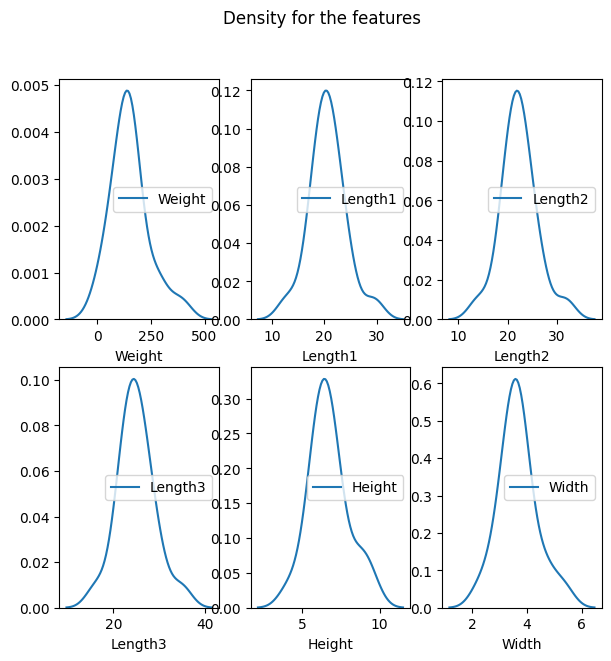

In [6]:
density_dataframe(df[df['Species']=='Roach'].drop('Species',1), 3 ,2, figsize=(7, 7) )

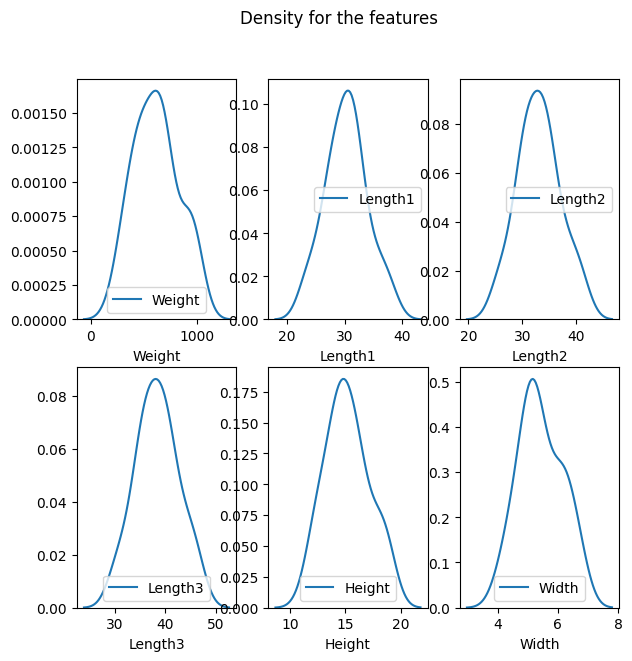

In [7]:
density_dataframe(df[df['Species']=='Bream'].drop('Species',1), 3 ,2, figsize=(7, 7) )

### Observation: 
It is clear that the probability distribution for each feature in the case of the two species are different.

let's look at the probability distribution of the features for every species.

Text(0.5, 0.98, 'distribution of the features for the species')

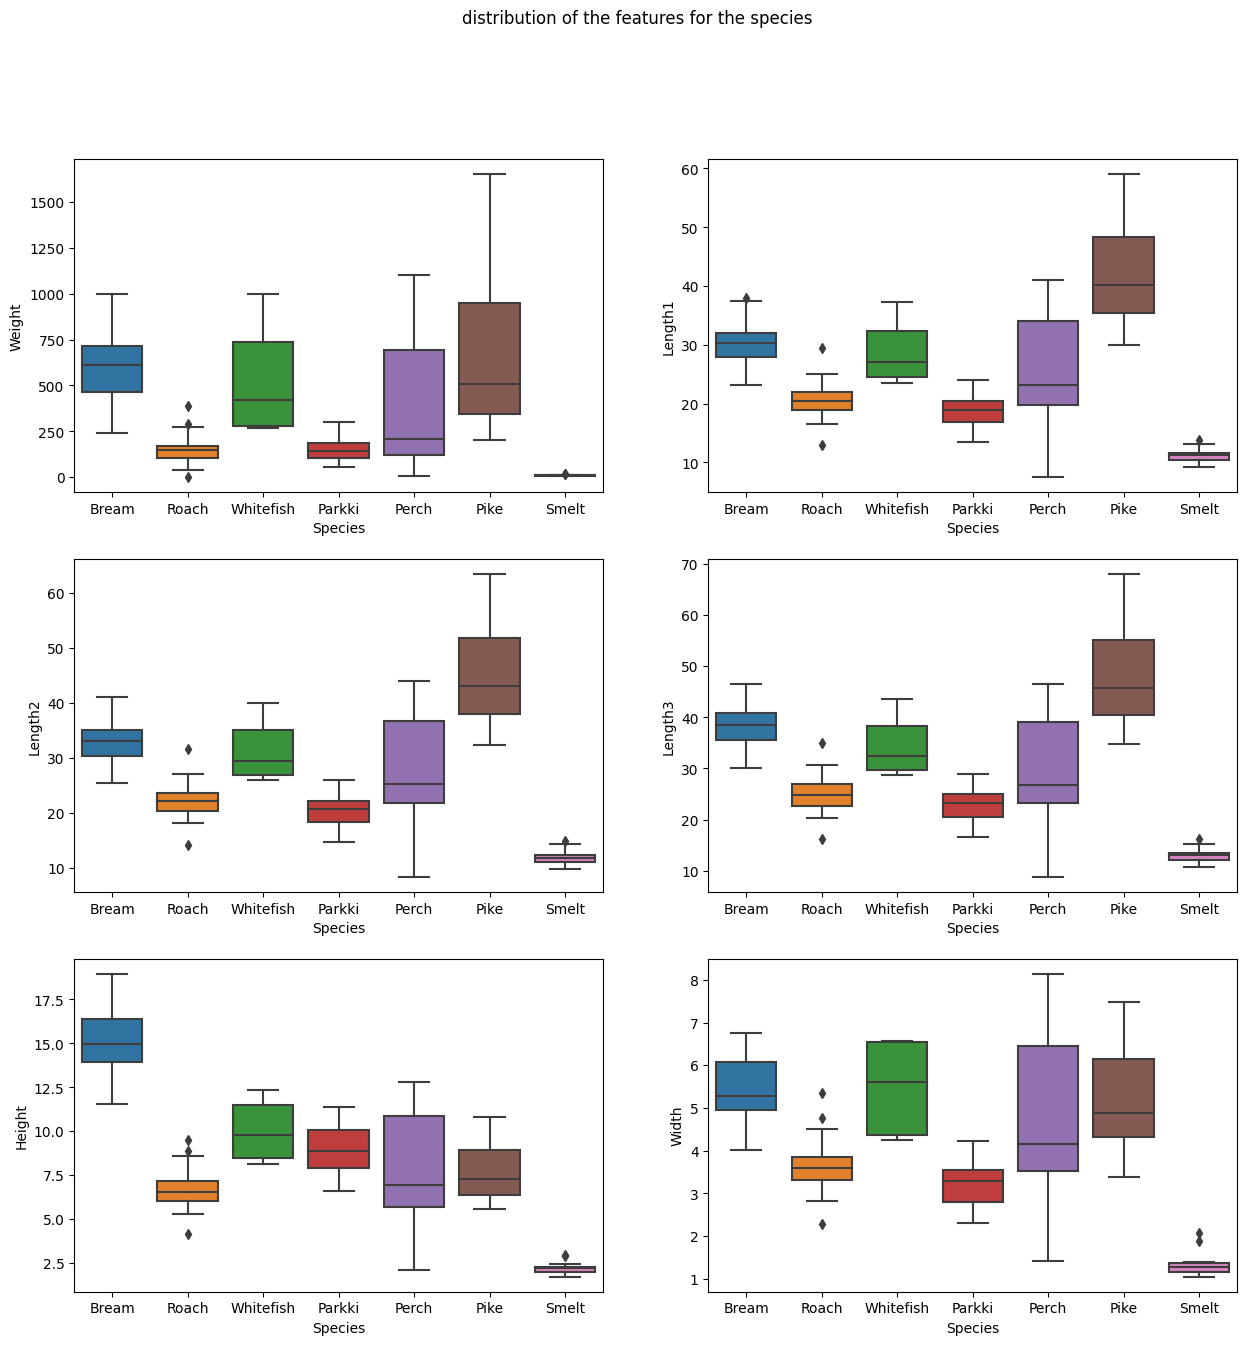

In [15]:
plt.figure(num=None, figsize=(15,15), dpi=100, facecolor="w", edgecolor="k")
for i, name in enumerate(df.columns[1:]):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x="Species", y=name, data= df)
plt.suptitle("distribution of the features for the species")

Parki and Roach seem to have the same distributions

In [17]:
compare_between_two_species('Parkki', 'Roach')

,Weight,Length1,Length2,Length3,Height,Width
0,1.992152,2.947795,3.007181,4.666712,7.530304,6.504756


- The PSI values are high compared to the rule of thumb used in the finance/banking industry ( important change in the probability distribution if PSI > 0.25 ).
- let's look at the probability distribution for the weight between the Parkki and the Roach

Text(0.5, 1.0, 'Parkki')

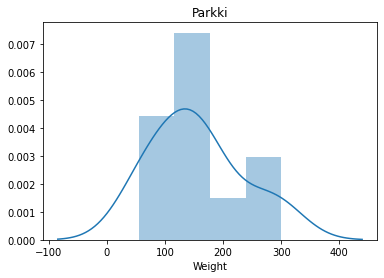

In [73]:
sns.distplot(df[df['Species']=='Parkki']['Weight'])
plt.title('Parkki')

Text(0.5, 1.0, 'Roach')

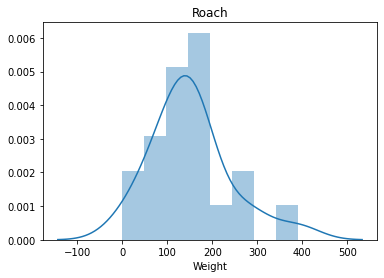

In [74]:
sns.distplot(df[df['Species']=='Roach']['Weight'])
plt.title('Roach')

#### ==> Difference in the probability distribution ( the Roach reaches higher values than the Parkki and at the same time it has lower values in the weight : a wider range values ) 

There is an information that we should leverage in order to have a more rigorous analysis: The age of the fish.Indeed, we don't have any information about the age of the fish and if we did we would have divided the intervals by range of age in order to compare the distributions of the features regarding the age of the fish. Because we see here that the Roach has lower and higher values of weight at the same time. maybe the lower values concern "baby" roachs whereas for Parkkis maybe we had only adult ones... 
We can also use technical informations for biological specifications about the fish and then cap values regarding the age of each fish and after that do an analysis between the probability distribution for the features.

## Fish : What's the fish that looks the more like me? 
Calculate the mean PSI value over all the features between two species !

In [37]:
def most_similar(species):
    list_species = list(set(df['Species'].unique()) - set([species]))
    list_psi_values = list()
    for i in list_species:
        list_psi_values.append(compare_between_two_species(species, i, division_method="quantiles").mean(axis=1)[0])
    return(pd.DataFrame([list_psi_values], columns = list_species))

In [38]:
most_similar('Roach')

,Smelt,Parkki,Perch,Bream,Whitefish,Pike
0,15.777685,5.562868,1.562959,14.266855,12.971687,12.609156


For the roach, the most ressemblant species is the Perch ( mean PSI of 1.56)

let's plot a graph where the large edges show similar probability distributions and dashed edges show very different probability distributions

In [69]:
def draw_graph(df, thresold_psi=3):
    first_list = list()
    G = nx.Graph()
    for value in  df['Species'].unique():
        first_list.append(value)
        list_species = list(set(df['Species'].unique()) - set(first_list))
        for i in list_species:
            G.add_edge(value, i, weight=compare_between_two_species(value, i, division_method="quantiles").mean(axis=1)[0])
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < thresold_psi]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresold_psi]

    pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="b", style="dashed"
    )

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.axis("off")
    plt.show()


example 1 :  all mean PSI values < 3 are regarded as being low ( which is false, but just for the sake of demonstration)

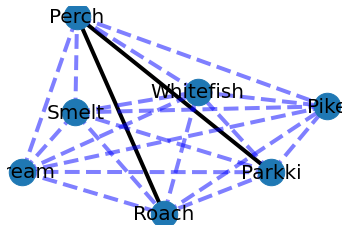

In [71]:
draw_graph(df)

- We see that the perch looks like the parkki and the roach 

example 2 : all mean PSI values < 10 are regarded as being low ( which is even more false, but just for the sake of demonstration)

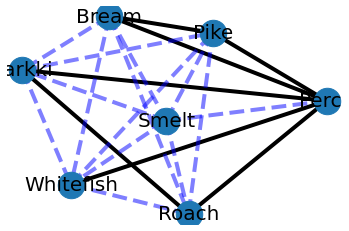

In [72]:
draw_graph(df, 10)

- The perch have lower PSI values with other species ( middle values as you can see in the boxplots)